# Credit Card Transaction Data Processing with PySpark

## ** 1. Import required libraries **

Start by importing necessary libraries from PySpark:

In [53]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType, DateType, DoubleType, BooleanType
from pyspark.sql.functions import (
                                    col, explode, from_json, from_utc_timestamp, regexp_replace, split, trim, concat, 
                                    lit, sha2, substring, avg, sum, max, min, count, year, month, round, format_number
                                  )

## ** 2. Initialize spark session **

In [ ]:
spark = SparkSession.builder.appName("CCsample").getOrCreate()

## ** 3. Read JSON data into a DataFrame **

In [ ]:
df_raw = spark.read.option("inferSchema","true").json("cc_sample/cc_sample_transaction.json")

## ** 4. JSON flattening **

In [ ]:
# Sample JSON schema of `personal_detail`
personal_detail_schema = StructType([
    StructField("person_name", StringType()),
    StructField("gender", StringType()),
    StructField("address", StringType()),
    StructField("lat", StringType()),
    StructField("long", StringType()),
    StructField("city_pop", StringType()),
    StructField("job", StringType()),
    StructField("dob", DateType())
])

# Schema for `address` (nested inside `personal_detail`)
address_schema = StructType([
    StructField("street", StringType()),
    StructField("city", StringType()),
    StructField("state", StringType()),
    StructField("zip", StringType())
])

# Convert `personal_detail` from STRING to STRUCT
df_flat_pd = df_raw.withColumn("personal_detail", from_json(col("personal_detail"), personal_detail_schema))

# Convert `address` (inside `personal_detail`) from STRING to STRUCT
df_flat_address = df_flat_pd.withColumn("address", from_json(col("personal_detail.address"), address_schema))


## ** 5. Cleaning card owner name and extract first name & last name **

In [ ]:
df_clean_name = df_flat_address.withColumn("clean_name", regexp_replace("personal_detail.person_name", "[^a-zA-Z]", " "))\
                            .withColumn("clean_name", trim(regexp_replace("clean_name", r"\s+", " "))) \
                            .withColumn("first", split("clean_name", " ")[0]) \
                            .withColumn("last", split("clean_name", " ")[1])

## ** 6. Handle EPOCH timestamp **

In [ ]:
df_clean_epoch = df_clean_name.withColumn(
                        "clean_eff_time",
                        F.when(F.length(F.col("merch_eff_time")) == 10,  # Epoch in seconds
                            from_utc_timestamp(F.from_unixtime(F.col("merch_eff_time")),"Asia/Singapore"))
                        .when((F.length(F.col("merch_last_update_time")) == 11),  # Epoch in milliseconds
                            from_utc_timestamp(F.from_unixtime(concat(F.col("merch_last_update_time"),F.lit("00")) / 1000),"Asia/Singapore"))
                        .when((F.length(F.col("merch_last_update_time")) == 12),  # Epoch in milliseconds
                            from_utc_timestamp(F.from_unixtime(concat(F.col("merch_last_update_time"),F.lit("0")) / 1000),"Asia/Singapore"))
                        .when((F.length(F.col("merch_last_update_time")) == 13),  # Epoch in milliseconds
                            from_utc_timestamp(F.from_unixtime(F.col("merch_last_update_time") / 1000),"Asia/Singapore"))
                        .when((F.length(F.col("merch_eff_time")) == 13),  # Epoch in milliseconds
                            from_utc_timestamp(F.from_unixtime(F.col("merch_eff_time") / 1000),"Asia/Singapore"))
                        .when(F.length(F.col("merch_eff_time")) == 16,  # Epoch in microseconds
                            from_utc_timestamp(F.from_unixtime(F.col("merch_eff_time") / 1_000_000),"Asia/Singapore"))
                        .otherwise(None)  # Handle invalid values
                    ) \
                   .withColumn(
                        "clean_merch_last_update_time",
                        F.when((F.length(F.col("merch_last_update_time")) == 10),  # Epoch in seconds
                            from_utc_timestamp(F.from_unixtime(F.col("merch_last_update_time")),"Asia/Singapore"))
                        .when((F.length(F.col("merch_last_update_time")) == 11),  # Epoch in milliseconds
                            from_utc_timestamp(F.from_unixtime(concat(F.col("merch_last_update_time"),F.lit("00")) / 1000),"Asia/Singapore"))
                        .when((F.length(F.col("merch_last_update_time")) == 12),  # Epoch in milliseconds
                            from_utc_timestamp(F.from_unixtime(concat(F.col("merch_last_update_time"),F.lit("0")) / 1000),"Asia/Singapore"))
                        .when((F.length(F.col("merch_last_update_time")) == 13),  # Epoch in milliseconds
                            from_utc_timestamp(F.from_unixtime(F.col("merch_last_update_time") / 1000),"Asia/Singapore"))
                        .when(F.length(F.col("merch_last_update_time")) == 16,  # Epoch in microseconds
                            from_utc_timestamp(F.from_unixtime(F.col("merch_last_update_time") / 1_000_000),"Asia/Singapore"))
                        .otherwise(None)  # Handle invalid values
                   )

## ** 7. Handle PII Data **

Use SHA-256 method for Credit Card Numbers.

Reasons:
1. Strong Irreversibility (One-Way Function).
    - SHA-256 is a cryptographic hash function, meaning it is one-way and cannot be reversed into the original CC number.
    - This prevents from retrieval of actual CCNs. Even if it leaked.

2. Consistent Length and Format.
    - A credit card number (typically 16 digits) will always result in a fixed 64-character hash, making storage uniform and predictable.

3. Privacy Compliance (PII Protection).
    - Storing raw CCNs violates PCI DSS (Payment Card Industry Data Security Standard).
    - Hashing removes CCNs from being classified as sensitive, reducing liability and compliance risk.

4. Enables Transaction Tracking & Fraud Detection.
    - If the same CC is used multiple times, it will generate the same SHA-256 hash, allowing analysis of fraud patterns without exposing actual CCNs.
    - This allows grouping transactions by hashed CCN for fraud analysis.

In [50]:
df_pii = df_clean_epoch.withColumn("cc_num", sha2("cc_num", 256))

## ** 8. Finilize schema, ready for analysis **

In [52]:
# Select flattened columns
df_flat = df_pii.select(
    "Unnamed: 0",
    from_utc_timestamp(col("trans_date_trans_time"),"Asia/Singapore").alias("trans_date_trans_time"),
    "cc_num",
    "merchant",
    "category",
    col("amt").cast(DoubleType()),
    "first",
    "last",
    col("personal_detail.gender").alias("gender"),
    col("address.street").alias("street"),
    col("address.city").alias("city"),
    col("address.state").alias("state"),
    col("address.zip").alias("zip"),
    col("personal_detail.lat").alias("lat"),
    col("personal_detail.long").alias("long"),
    col("personal_detail.city_pop").alias("city_pop").cast(IntegerType()),
    col("personal_detail.job").alias("job"),
    col("personal_detail.dob").alias("dob"),
    "trans_num",
    "merch_lat",
    "merch_long",
    col("is_fraud").cast(BooleanType()),
    "merch_zipcode",
    col("clean_merch_last_update_time").alias("merch_last_update_time"),
    col("clean_eff_time").alias("merch_eff_time"),
    "cc_bic"
)


## ** Total Spending by Month **

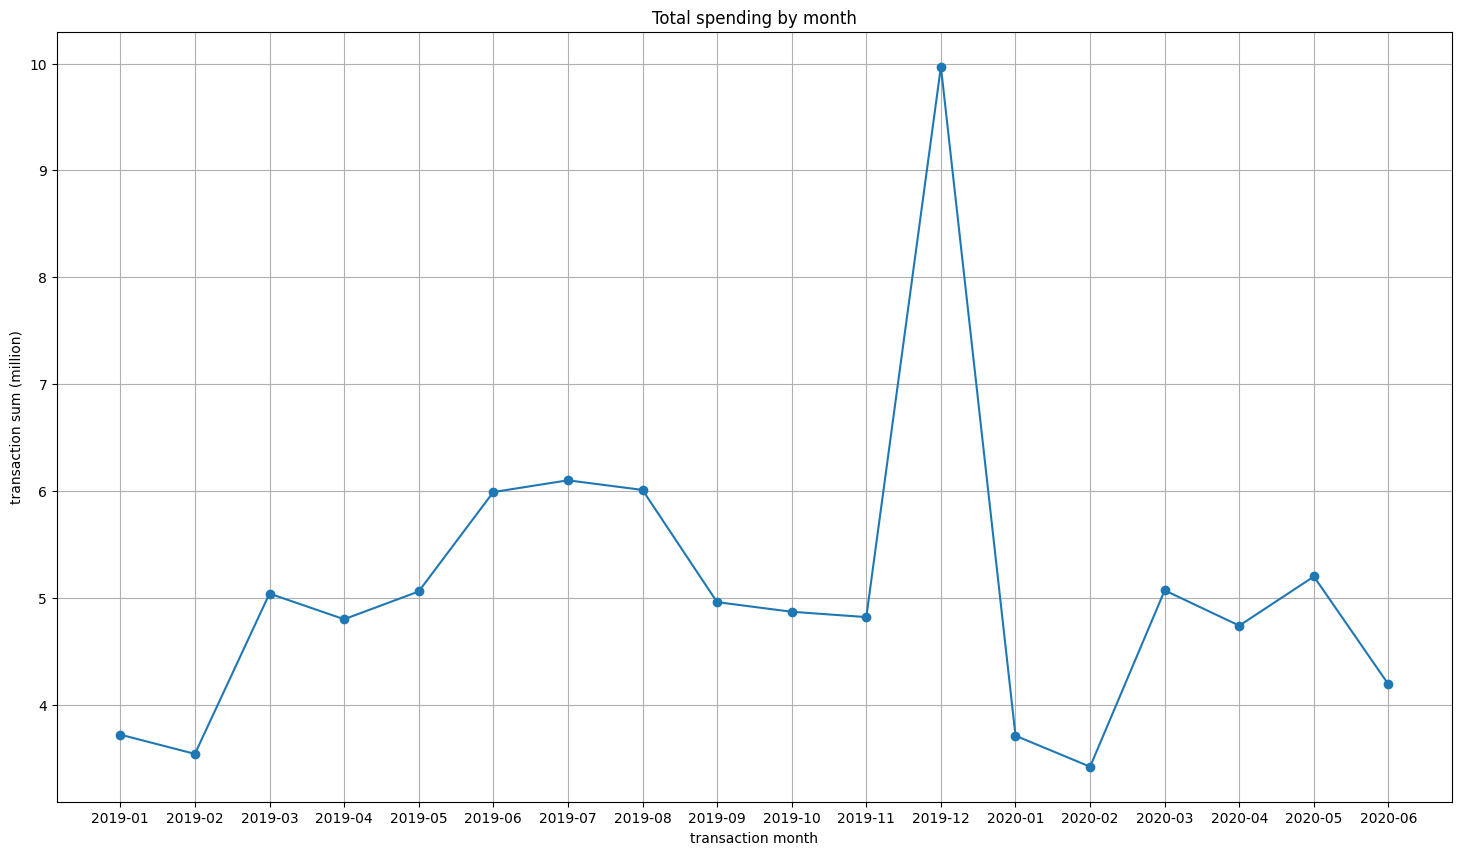

In [40]:
import matplotlib.pyplot as plt
import pandas as pd

total_trans = df_flat.withColumn("trans_year_month", substring("trans_date_trans_time", 0, 7))\
                     .groupBy("trans_year_month")\
                     .agg(round(sum("amt")/1000000,2).alias("trans_sum"))

pandas_df = total_trans.select("trans_year_month", "trans_sum").orderBy(col("trans_year_month")).toPandas()

plt.figure(figsize=(18, 10))
plt.plot(pandas_df["trans_year_month"], pandas_df["trans_sum"], marker = "o")
plt.xlabel("transaction month")
plt.ylabel("transaction sum (million)")
plt.title("Total spending by month")
plt.grid(True)
plt.show()


## ** Average Transaction Amount by Month **

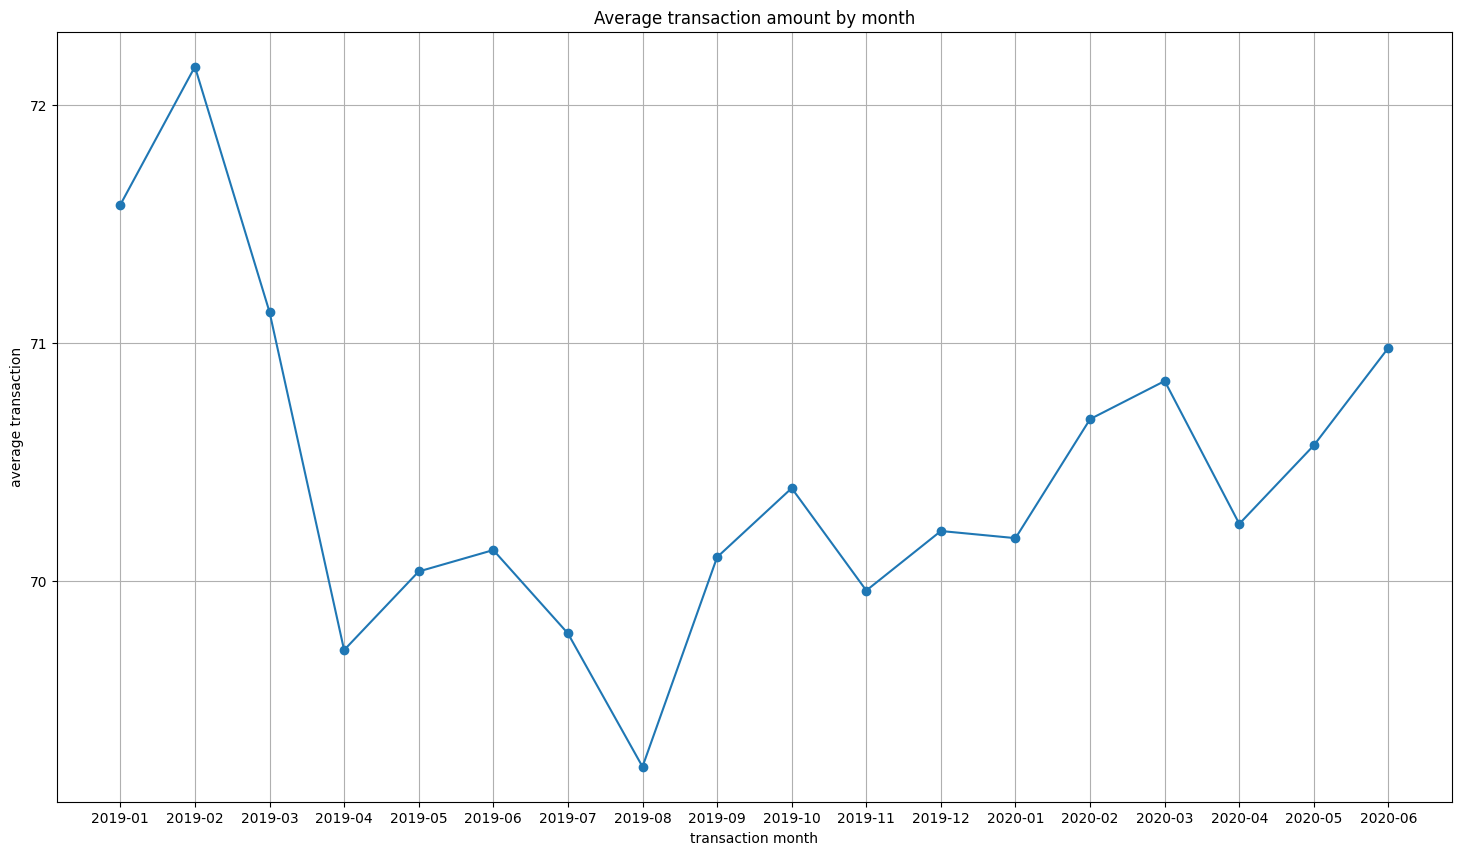

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as mticker

avg_amt_spend = df_flat.withColumn("trans_year_month", substring("trans_date_trans_time", 0, 7))\
                       .groupBy("trans_year_month")\
                       .agg(round(avg("amt"),2).alias("trans_sum"))

pandas_df = avg_amt_spend.select("trans_year_month", "trans_sum").orderBy(col("trans_year_month")).toPandas()

plt.figure(figsize=(18, 10))
plt.plot(pandas_df["trans_year_month"], pandas_df["trans_sum"], marker = "o")
plt.xlabel("transaction month")
plt.ylabel("average transaction")
plt.title("Average transaction amount by month")
plt.grid(True)
plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(1))
plt.show()

## ** Top 10 Merchant **

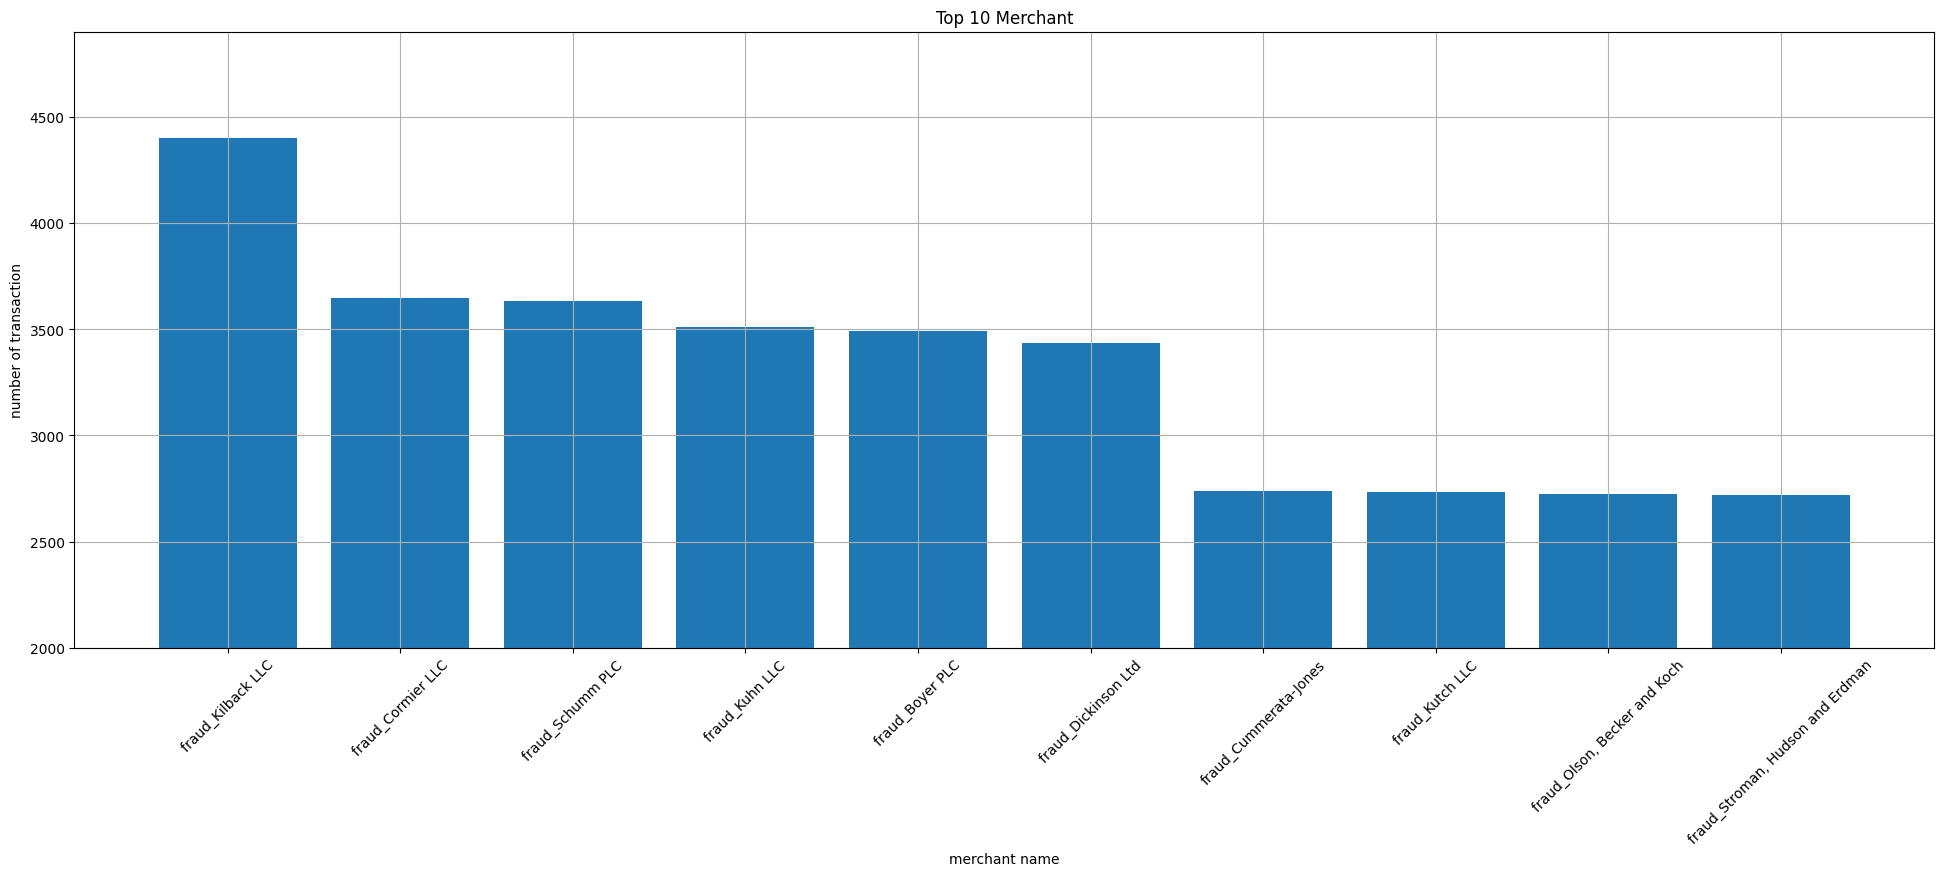

In [58]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as mticker

top_ten_merch = df_flat.groupBy("merchant")\
                       .agg(count("trans_num").alias("number_of_trans"))\
                       .distinct()\
                       .orderBy(col("number_of_trans").desc())\
                       .limit(10)

pandas_df = top_ten_merch.toPandas()

plt.figure(figsize=(24, 8))
plt.bar(pandas_df["merchant"], pandas_df["number_of_trans"])
plt.xlabel("merchant name")
plt.ylabel("number of transaction")
plt.title("Top 10 Merchant")
plt.ylim(2000, pandas_df["number_of_trans"].max() + 500)
plt.yticks(range(2000, pandas_df["number_of_trans"].max() + 500, 500))
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


## ** Top 10 Fraud Transaction by Merchant **

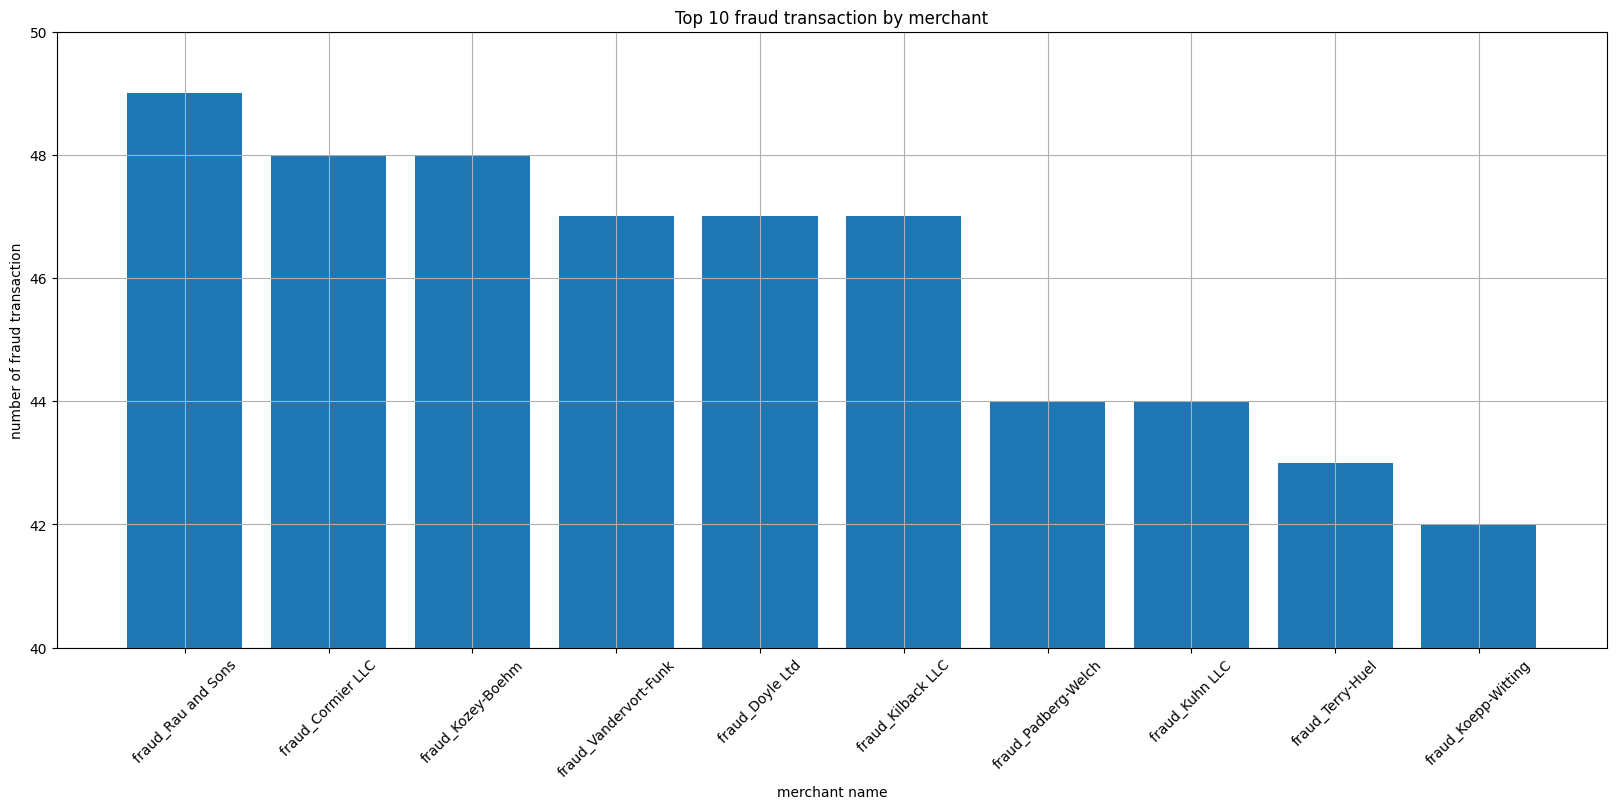

In [57]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as mticker

top_ten_fraud_merch = df_flat.filter(col("is_fraud") == "true")\
                       .groupBy("merchant")\
                       .agg(count("trans_num").alias("number_of_trans"))\
                       .distinct()\
                       .orderBy(col("number_of_trans").desc())\
                       .limit(10)

pandas_df = top_ten_fraud_merch.toPandas()

plt.figure(figsize=(20, 8))
plt.bar(pandas_df["merchant"], pandas_df["number_of_trans"])
plt.xlabel("merchant name")
plt.ylabel("number of fraud transaction")
plt.title("Top 10 fraud transaction by merchant")
plt.ylim(40, pandas_df["number_of_trans"].max() + 1)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## ** Category Spending Distribution **

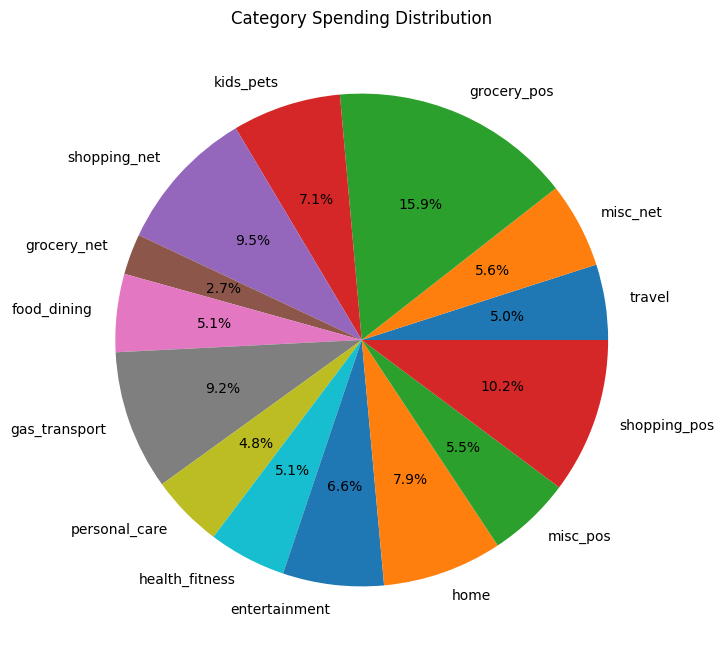

In [59]:
cat_spending = df_flat.groupBy("category").agg(sum("amt").alias("total_cat_spending"))

total_spending = df_flat.agg(sum("amt").alias("grand_total")).collect()[0]["grand_total"]

category_percentage = cat_spending.withColumn(
    "spending_percentage", round((col("total_cat_spending") / total_spending) * 100, 2)
)

pandas_df = category_percentage.toPandas()

# Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(pandas_df["spending_percentage"], labels=pandas_df["category"], autopct='%1.1f%%')

# Title
plt.title("Category Spending Distribution")

# Show Plot
plt.show()